In [ ]:
#instructions for how to build this using nbdev at https://nbdev.fast.ai/

In [ ]:
#default_exp predict

# Predict loaded articles

> Takes a loader as an argument

In [ ]:
#export
from newstrends import loader
import pandas as pd
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
class predicter(loader.article_holder):
    
    def __init__(self):
        super().__init__()

        

In [ ]:
#export
class predicter(predicter):
    def getOneStepForecast(self, steps:int=1, model:str="sarimax"):
        print(df.columns)
        return -1
    


In [ ]:
tmp = loader.article_holder()
tmp.set_articleDir(path="../CoverageTrends")
tmp.load_articles(publications=["newyorktimes", "washingtonpost"])


In [ ]:
#export
class predicter(predicter):
    def transformTimeSeries(self, keyword:str="", publishers:list=[], timeStart=-1, timeEnd=-1, aggregate="h"):   
        if keyword == "":
            raise Exception("Pass a keyword")
        if type(keyword)!=str:
            raise Exception("Pass keyword as a string")

        df= self.df.copy()
        df = df[df.tokens.apply(lambda x: keyword in x)]
                    
        df.date = pd.to_datetime(df.date)
        df.set_index("date", inplace=True)

        newDF = pd.DataFrame()
        for src in publishers:
            newDF[src] = df[df.source==src].resample(aggregate).count()["quickReplace"]
        df=newDF
        if len(df) < 1:
            raise Exception("No data in time series")
        self.timeDF = df.fillna(0)

    

In [ ]:
class predicter(predicter):
    def test_train_split(self, testSize):
        if testSize > 0:
            self.train=self.timeDF[:-testSize]
            self.test=self.timeDF[-testSize:]
        else:
            self.train=self.timeDF

In [ ]:
#export
class predicter(predicter):
    
    def simpleSarimaxModel(self, endogenous:str, exogenous=[], timeStart=-1, timeEnd=-1, aggregate="h", m=24, ic:["oob", "aic"]="oob"):
        
        try:
            if len(self.train) < 1:
                raise Exception("")
            
        except:
            raise Exception("No transformed time series; run test_train split")
            
        
        mDict={
            "D":7,
            "h":24,
        }
        try:
            m=mDict[aggregate]
        except:
            pass
        
        df = self.timeDF.resample(aggregate).sum()
        
        endo = df[[endogenous]]

        if len(exogenous) > 0:
            endo = endo[1:]
            exog = df[exogenous].shift()[1:]
            model = auto_arima(endo, exogenous=exog, out_of_sample_size=3*m, information_criterion=ic, m=m, stepwise=True, trace=True)
            
        else:
            model = auto_arima(endo, out_of_sample_size=24, information_criterion=ic, m=m, stepwise=True, trace=True)
        

        return model

# what we need to do is make a model for our endogenous and exogenous series on the training set. Then, to keep the trained model results without changing them we fit a new model to the full (or test) data set and then filter it on the original params
(see https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html)

In [ ]:
p = predicter()
p.load_article_holder(tmp)
p.transformTimeSeries(keyword="floyd", publishers=["newyorktimes", "washingtonpost"])
p.test_train_split(48)

In [ ]:
model = p.simpleSarimaxModel("newyorktimes", exogenous=["washingtonpost"], aggregate="h")

Performing stepwise search to minimize oob
Fit ARIMA: (2, 0, 2)x(1, 0, 1, 24) (constant=True); AIC=1021.314, BIC=1057.460, Time=4.430 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 24) (constant=True); AIC=1642.447, BIC=1654.496, Time=0.096 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 24) (constant=True); AIC=1036.365, BIC=1056.446, Time=1.143 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 24) (constant=True); AIC=1326.047, BIC=1346.128, Time=1.190 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 24) (constant=False); AIC=1678.089, BIC=1686.121, Time=0.090 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 24) (constant=True); AIC=1325.061, BIC=1341.126, Time=0.147 seconds
Fit ARIMA: (0, 0, 1)x(1, 0, 1, 24) (constant=True); AIC=1327.305, BIC=1351.402, Time=2.104 seconds
Fit ARIMA: (0, 0, 1)x(1, 0, 0, 24) (constant=True); AIC=1325.746, BIC=1345.827, Time=1.006 seconds
Fit ARIMA: (0, 0, 1)x(2, 0, 1, 24) (constant=True); AIC=1329.140, BIC=1357.254, Time=7.625 seconds
Fit ARIMA: (0, 0, 1)x(1, 0, 2, 24) (constant=True); AIC=1329.142,

In [ ]:
endogenous="newyorktimes"
endo = p.timeDF[[endogenous]][1:]
exog = p.timeDF[[x for x in p.timeDF.columns if x != endogenous]].shift()[1:]

In [ ]:
tmp = SARIMAX(endo, exogenous=exog, order = model.order, seasonal_order=model.seasonal_order)

In [ ]:
res = tmp.filter(model.params())

In [ ]:
endo["yhat"] = res.predict(exogenous=exog)

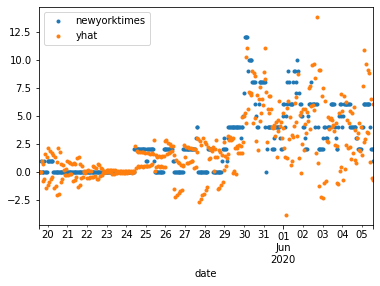

In [ ]:
endo.plot(style=".")

In [ ]:
endo["resid"] = endo[endogenous]-endo.yhat

In [ ]:
endo["percent_error"] = 100*np.abs(endo["resid"]/endo[endogenous])

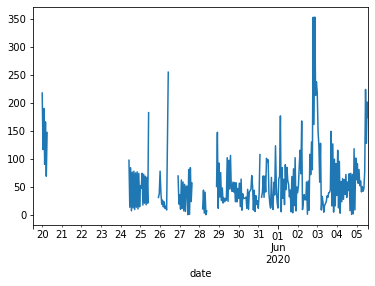

In [ ]:
endo["percent_error"].plot()

In [ ]:
model

ARIMA(maxiter=50, method='lbfgs', order=(0, 0, 2), out_of_sample_size=72,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 2, 24),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [ ]:
#export
class predicter(predicter):
    "generate best model for each series in the loaded time series dataframe"
    def generateMultivarSARIMAXResults(self):
        self.multiVarResults = {}
        
        for publication in self.test.columns:
            #hmm, doing for arbetrary numbers, I should be able to assume that pvalues/params of i correspond
            self.multiVarResults[publication] = {}
            
            endogenous = publication
            exogenous = [x for x in self.test.columns if x != publication]
            
            model = self.simpleSarimaxModel(endogenous, exogenous=exogenous, aggregate="h")
            
            endo = p.timeDF[[endogenous]][1:].copy()
            exog = p.timeDF[exogenous].shift()[1:]

            if model.with_intercept:
                newModel = SARIMAX(endo, exog=exog, order = model.order, seasonal_order=model.seasonal_order, trend='c')
            else:
                newModel = SARIMAX(endo, exog=exog, order = model.order, seasonal_order=model.seasonal_order)
                
            newModel = newModel.filter(model.params())
            
            endo["yhat"] = newModel.predict(exogenous=exog)
                        
            self.multiVarResults[publication]["params"] = newModel.params
            self.multiVarResults[publication]["pvalues"] = newModel.pvalues
            self.multiVarResults[publication]["results"] = endo
            
        
            

In [ ]:
tmp = loader.article_holder()
tmp.set_articleDir(path="../CoverageTrends")
tmp.load_articles(publications=["newyorktimes", "washingtonpost"])


p = predicter()
p.load_article_holder(tmp)
p.transformTimeSeries(keyword="floyd", publishers=["newyorktimes", "washingtonpost"])
p.test_train_split(48)

In [ ]:
p.generateMultivarSARIMAXResults()

Performing stepwise search to minimize oob
Fit ARIMA: (2, 0, 2)x(1, 0, 1, 24) (constant=True); AIC=1021.314, BIC=1057.460, Time=4.792 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 24) (constant=True); AIC=1642.447, BIC=1654.496, Time=0.102 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 24) (constant=True); AIC=1036.365, BIC=1056.446, Time=1.179 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 24) (constant=True); AIC=1326.047, BIC=1346.128, Time=1.210 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 24) (constant=False); AIC=1678.089, BIC=1686.121, Time=0.094 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 24) (constant=True); AIC=1325.061, BIC=1341.126, Time=0.150 seconds
Fit ARIMA: (0, 0, 1)x(1, 0, 1, 24) (constant=True); AIC=1327.305, BIC=1351.402, Time=2.238 seconds
Fit ARIMA: (0, 0, 1)x(1, 0, 0, 24) (constant=True); AIC=1325.746, BIC=1345.827, Time=1.065 seconds
Fit ARIMA: (0, 0, 1)x(2, 0, 1, 24) (constant=True); AIC=1329.140, BIC=1357.254, Time=7.700 seconds
Fit ARIMA: (0, 0, 1)x(1, 0, 2, 24) (constant=True); AIC=1329.142,

In [ ]:
pd.DataFrame(p.multiVarResults)

,newyorktimes,washingtonpost
params,intercept 1.269209 washingtonpost 0...,newyorktimes 0.172732 sigma2 2.462...
pvalues,intercept 1.080625e-06 washingtonpost...,newyorktimes 6.907657e-03 sigma2 ...
results,newyorktimes yhat da...,washingtonpost yhat...
